In [1]:
import pickle
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import copy

In [2]:
np.random.seed(42)

In [3]:
N_players = 5
players = [f'player{i}' for i in range(1, N_players+1)]
n_components = 3 # num of hidden states
n_features = 3 # num of observed states
O_symbols = [0, 1, 2] # under-, avg-, over- performance
H_symbols = [0, 1, 2] # corresponding mental states
T = 100
learning_iterations = 100

In [4]:
class TeamModel:
    def __init__(self, initial_dist, M, N, R, emission_prob):
        self.initial_dist = initial_dist
        
        # Transition matrices
        self.M = M # dictionary. key = player, value = a row-stochastic matrix, observation-to-state transitions
        self.N = N # dictionary. key = player, value = a row-stochastic matrix, state-to-state transitions
        
        # Graph weights - Tie strengh
        self.R = R # row-stochastic matrix
        
        # Emission matrices
        self.emission_prob = emission_prob # for each player, a row-stochastic matrix
        
        # Store latest hidden and observed states
        self.H = None
        self.O = None
    
        self.t = 0
   
    
    def next(self):
        if self.t == 0:
            self.H = {p: np.random.choice(H_symbols, p=self.initial_dist) for p in players}
            self.O = {p: np.random.choice(O_symbols, p=self.emission_prob[p][self.H[p]]) for p in players}
            self.t = 1
            
            return self.H, self.O
            
        H_new = {}
        O_new = {}
        for p in players:
            R_ = self.R[p]
            emission_ = self.emission_prob[p]
            
            # produce next hidden state
            dist = []
            for h in H_symbols: # calculate the probability of each next state h
                v = []
                v.append(self.N[p][self.H[p]][h]) # P(H_t^player = h | H__{t-1}^player = H[player])
                for teammate in players:
                    if (p, teammate) in M:
                        v.append(self.M[(p, teammate)][self.O[teammate]][h]) # P(H_t^player = h | O_{t-1}^teammate = O[teammate])
                    else:
                        v.append(self.M[p][self.O[teammate]][h])
                v = np.array(v)
                
                dist.append(np.dot(R_, v))
            
            h_new = np.random.choice(H_symbols, p=dist)
            
            # produce next observation
            o_new = np.random.choice(O_symbols, p=emission_[h_new])
            
            # Add new values to
            H_new[p] = h_new
            O_new[p] = o_new
            
        # Update hidden and observed states
        self.H = H_new
        self.O = O_new
        
        # Update time
        self.t += 1
        
        return H_new, O_new
    
    def get_data(self, T = 1000):
        # T = number of observations (i.e. number of iterations)
        self.restart()
        data = []
        for _ in range(T):
            H, O = self.next()
            data.append((H, O))
        return data
    
    def restart(self):
        self.H = None
        self.O = None
        self.t = 0

In [5]:
# === M ===
avg_transO = np.array([[0.5, 0.3, 0.2],
                       [0.25, 0.5, 0.25],
                       [0.2, 0.3, 0.5]])

star_transO = np.array([[0.7, 0.3, 0],
                        [0.1, 0.8, 0.1],
                        [0, 0.3, 0.7]])
# === N ===
avg_transH = np.array([[0.8, 0.2, 0.0],
                       [0.1, 0.8, 0.1],
                       [0.0, 0.2, 0.8]])

# === emission_prob ===
avg_emission = np.array([[0.7, 0.3, 0],
                       [0.1, 0.8, 0.1],
                       [0.0, 0.3, 0.7]])

# ===  R ===
R_singleH = np.array([1] + [0] * len(players))
def R_singleHO(player):
    i = int(player[-1])
    arr = [0] * (len(players)+1)
    arr[0] = 0.7
    arr[i] = 0.3
    return np.array(arr)

def R_singleO(player):
    i = int(player[-1])
    arr = [0] * (len(players)+1)
    arr[i] = 1
    return np.array(arr)

def R_star(player, star):
    if player == star:
        return R_singleH
    arr = [0] * (len(players)+1)
    i = int(star[-1])
    arr[i] = 1
    return np.array(arr)
    
R_uniform = np.array([1/(1 + len(players))] * (len(players) + 1))

In [6]:
def generate_data(model, T, seed=73):
    np.random.seed(seed)
    data = []
    data = model.get_data(T)

    # Store data
    observations = {player: [] for player in players}
    true_hidden = {player: [] for player in players}
    for (h, o) in data:
        for player in players:
            true_hidden[player].append(h[player])
            observations[player].append(o[player])

    for player in players:
        observations[player] = np.array(observations[player])
        true_hidden[player] = np.array(true_hidden[player])
    return observations, true_hidden

In [7]:
M = {player: star_transO for player in players}
N = {player: avg_transH for player in players}
emission_prob = {player: avg_emission for player in players}
R = {player: R_star(player, 'player1') for player in players}
initial_dist = np.array([0, 1, 0])

model = TeamModel(initial_dist, M, N, R, emission_prob)

In [8]:
# Generate data
Os, Hs = generate_data(model, T)

with open('./observations.pkl', 'wb') as file:
    pickle.dump(Os, file)
with open('./hidden.pkl', 'wb') as file:
    pickle.dump(Hs, file)

In [9]:
def init_trans():
    trans_mat = np.zeros((n_components, n_components))
    
    trans_mat[0][0] = np.random.uniform(0.5, 1)
    trans_mat[0][1] = 1 - trans_mat[0][0]
    trans_mat[0][2] = 0.0
    
    trans_mat[1][1] = np.random.uniform(0.5, 1)
    trans_mat[1][0] = (1 - trans_mat[1][1]) / 2
    trans_mat[1][2] = (1 - trans_mat[1][1]) / 2
    
    trans_mat[2][2] = np.random.uniform(0.5, 1)
    trans_mat[2][0] = 0.0
    trans_mat[2][1] = 1 - trans_mat[2][2]
    
    return trans_mat

def init_random():
    mat = np.random.random((n_features, n_components))
    for i in range(n_features):
        mat[i] = mat[i] / np.sum(mat[i])
    return mat

def init_R():
    R = dict()
    for p in players:
        # populate R[p] with random numbers
        R[p] =  np.random.rand(N_players + 1)
        
        # randomly select entries and set them to 0
        nums = np.random.choice(range(N_players + 1), np.random.choice(range(N_players)), replace=False)
        for i in nums:
            R[p][i] = 0
            
        # normalize
        R[p] = R[p] / np.sum(R[p])
    
    return R

In [10]:
def cond(player, h1, h2, t, M_, N_, R_): # P(H_t^player = h1 | H_{t-1}^player = h2, O_{t-1})    
    # Requires M_, N_, R_, Os
    v = [N_[h2][h1]]
    for teammate in players:
        v.append(M_[Os[teammate][t-1]][h1])
            
    v = np.array(v)
    return np.dot(R_[player], v)  

In [11]:
def learn_R(M, N, samples, O):
    R = {p: cp.Variable(len(players) + 1, nonneg=True) for p in players}

    objective = 0
    for H in samples:
        for p in players:
            for t in range(1, T):
                h_t = H[p][t] # state of player p at time t
                v_t = [N[H[p][t-1]][h_t]]
                for teammate in players:
                    v_t.append(M[O[teammate][t-1]][h_t])
                v_t = np.array(v_t)
                prod = R[p] @ v_t
                objective -= cp.log(prod)

    R_constraints = [cp.sum(R[p]) == 1 for p in R]
    prob = cp.Problem(cp.Minimize(objective), R_constraints)
    prob.solve(solver=cp.MOSEK)
    
    R_optimized = {p: R[p].value for p in players}
    
    return R_optimized, prob.value

In [12]:
def learn_M_N(R, samples, O):
    M = cp.Variable((n_features, n_components), nonneg=True)
    N = cp.Variable((n_components, n_components), nonneg=True) 
    E = cp.Variable((n_components, n_features), nonneg=True)
    
    objective = 0
    for H in samples:
        for p in players:
            for t in range(1, T):
                h_t = H[p][t] # state of player p at time t
                v_t = [5*N[H[p][t-1], h_t]]
                for teammate in players:
                    v_t.append(M[O[teammate][t-1], h_t])
                v_t = np.array(v_t)
                prod = R[p] @ v_t
                objective -= cp.log(prod)
    
    M_constraints = [cp.sum(M[i, :]) == 1 for i in range(n_features)]
    N_constraints = [cp.sum(N[i, :]) == 1 for i in range(n_components)]
    
    constraints = M_constraints + N_constraints
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.MOSEK)
    
    M_optimized = M.value
    N_optimized = N.value
    
    return M_optimized, N_optimized, prob.value

In [13]:
def learn_E(samples, O):
    E = cp.Variable((n_components, n_features), nonneg=True)
    
    objective = 0
    for H in samples:
        for p in players:     
            for t in range(T):
                objective -= cp.log(E[H[p][t]][O[p][t]])
                
    E_constraints = [cp.sum(E[i, :]) == 1 for i in range(n_components)]
    prob = cp.Problem(cp.Minimize(objective), E_constraints)
    prob.solve(solver=cp.MOSEK)
    E_optimized = E.value
    
    return E_optimized, prob.value

In [14]:
def calculate_forward(M_, N_, E_, R_):
    alpha = {p: [] for p in players}
    alpha_help = {p: [] for p in players}
    
    # Initialize forward parameters
    for p in players:
        alpha_help[p].append(initial_dist)
    for p in players:
        arr = np.array([E_[h][Os[p][0]] * alpha_help[p][0][h] for h in H_symbols])
        arr /= np.sum(arr)
        alpha[p].append(arr)

    # Compute forward parameters (bottom-up)
    for p in players:
        for t in range(1, T):
            arr = [sum([cond(p, h, h_, t, M_, N_, R_) * alpha[p][t-1][h_] for h_ in H_symbols]) for h in H_symbols]
            arr = np.array(arr)
            alpha_help[p].append(arr)
            
            arr = [E_[h][Os[p][t]] * alpha_help[p][t][h] for h in H_symbols]
            arr = np.array(arr)
            arr /= np.sum(arr)
            alpha[p].append(arr)
            
    return alpha, alpha_help

In [15]:
def E_step(M_, N_, E_, R_, num_of_samples = 10):
    alpha, alpha_help = calculate_forward(M_, N_, E_, R_)
    
    # Sample hidden states from the posterior distribution
    samples = []
    for _ in range(num_of_samples):
        Hs_ = {p: [1] for p in players}

        for p in players:
            for t in range(1, T):
                dist = np.array([alpha[p][t][h] * cond(p, h, Hs_[p][t-1], t, M_, N_, R_) / alpha_help[p][t][h] if alpha_help[p][t][h] != 0 else 0 for h in H_symbols])
                dist /= np.sum(dist)
                Hs_[p].append(np.random.choice(H_symbols, p=dist))
        for p in players:
            Hs_[p] = np.array(Hs_[p])
        samples.append(copy.deepcopy(Hs_))
    
    return samples

def M_step(samples, M, N, R, iterations=1):
    M_opt = M
    N_opt = N
    R_opt = copy.deepcopy(R)
    for _ in range(iterations):
        try:
#                 R_opt, val1 = learn_R(M_opt, N_opt, samples, Os) # Fix M, N and maximize R
#                 M_opt, N_opt, val1 = learn_M_N(R_opt, samples, Os) # Fix R and maximize M, N

            M_opt, N_opt, val1 = learn_M_N(R_opt, samples, Os) # Fix R and maximize M, N
            R_opt, val1 = learn_R(M_opt, N_opt, samples, Os) # Fix M, N and maximize R
            E_opt, val2 = learn_E(samples, Os)
            
            val = val1 + val2
        except cp.error.SolverError as e:
            print(e)
            break
            
    return M_opt, N_opt, R_opt, E_opt, val

def EM(params, iterations = 10, reltol = 1e-3, inctol = 2):
    # Initialize parameters
    M_, N_, E_, R_ = params['M'], params['N'], params['E'], params['R']
    
    error = dict()
    error['M'] = []
    error['N'] = []
    error['E'] = []
    error['R'] = []
    error['objVal'] = []
    
    cntObjIncreasing = 0 # used for stopping EM
    val = 1e+100 # best objective value achieved so far
    M_opt = M_
    N_opt = N_
    E_opt = E_
    R_opt = copy.deepcopy(R_)
    error['M'].append(np.linalg.norm(M_opt - M_true))
    error['N'].append(np.linalg.norm(N_opt - N_true))
    error['E'].append(np.linalg.norm(E_opt - E_true))
    R_mat_true = np.vstack([R_true[p] for p in players])
    R_mat = np.vstack([R_opt[p] - R_true[p] for p in players])
    error['R'].append(np.linalg.norm(R_mat) / np.linalg.norm(R_mat_true))
    for i in range(iterations):
        print(f'=== EM iteration {i+1} ===')
        # E-step
        print(f'E-step...')
        samples = E_step(M_, N_, E_, R_)
        
        # M-step
        print(f'M-step...')
        M_, N_, R_, E_, obj_val = M_step(samples, M_, N_, R_)
        
        # Append errors
        error['M'].append(np.linalg.norm(M_opt - M_true) / np.linalg.norm(M_true))
        error['N'].append(np.linalg.norm(N_opt - N_true) / np.linalg.norm(N_true))
        error['E'].append(np.linalg.norm(E_opt - E_true) / np.linalg.norm(E_true))
        R_mat = np.vstack([R_opt[p] - R_true[p] for p in players])
        R_mat_true = np.vstack([R_true[p] for p in players])
        error['R'].append(np.linalg.norm(R_mat) / np.linalg.norm(R_mat_true))
        error['objVal'].append(obj_val / 10)
        print(f'\tObjVal = {obj_val / 10}')
         
        # Update current best parameters
        if obj_val < val:
            M_opt = M_
            N_opt = N_
            E_opt = E_
            R_opt = copy.deepcopy(R_)
        
        # Stopping conditions
#         if abs(val - obj_val) / val < reltol and obj_val < val:
#             break
        
#         cntObjIncreasing = 0 if obj_val <= val else cntObjIncreasing + 1
#         if cntObjIncreasing > inctol:
#             break
            
        # Update best objective value so far    
        val = min(val, obj_val)
        
    return M_opt, N_opt, R_opt, E_opt, val, error

In [16]:
def EM_helper(param_list):
    i = 1
    val_opt = 1e+100
    for params in param_list:
        print(f'==== EM run {i} ====')
        i += 1
        M_, N_, R_, E_, val, errors = EM(params)
        
        if val < val_opt:
            val_opt = val
            M_opt = M_
            N_opt = N_
            E_opt = E_
            R_opt = R_
            errors_opt = errors
            
    return M_opt, N_opt, R_opt, E_opt, val_opt, errors_opt

In [17]:
def print_params(M_, N_, E_, R_):
    print(f'M = {np.round(M_, 2)}')
    print(f'N = {np.round(N_, 2)}')
    print(f'E = {np.round(E_, 2)}')
    for p in players:
        print(f'R[{p}] = {np.round(R_[p], 2)}')

In [18]:
def likelihood(params): # Calculate log P(O) (given the model parameters)
    M, N, E, R = params['M'], params['N'], params['E'], params['R']

    # Caluclate forward parameters
    alpha, alpha_help = calculate_forward(M, N, E, R)
    obj = 0
    for p in players:
        for t in range(T):
            if isinstance(E, dict):
                obj += -np.log(sum([E[p][h][Os[p][t]] * alpha_help[p][t][h] for h in H_symbols])) # Pr(O_t^i | O_{1:t-1})
            else:
                obj += -np.log(sum([E[h][Os[p][t]] * alpha_help[p][t][h] for h in H_symbols])) # Pr(O_t^i | O_{1:t-1})

    return obj

def likelihood_test(params_list):
    # Given a list of model parameters returns the model parameters that achieve the highest likelihood
    val_opt = 1e+100
    for params in params_list:
        val = likelihood(params)
        if val < val_opt:
            val_opt = val
            params_opt = params
    return params_opt

In [19]:
M_true = star_transO
N_true = avg_transH
E_true = avg_emission
R_true = {p: R_star(p, 'player1') for p in players}

In [20]:
params = dict()
params['M'] = star_transO
params['N'] = avg_transH
params['E'] = avg_emission
params['R'] = {player: R_star(player, 'player1') for player in players}
likelihood(params)

417.07776529444584

In [21]:
# np.random.seed(42)
# params_list = list()
# M_init = init_trans()
# N_init = init_trans()
# E_init = init_trans()
# R_init = {p: R_uniform for p in players}
# params = dict()
# params['M'] = M_init
# params['N'] = N_init
# params['E'] = E_init
# params['R'] = R_init
# print(f'Initial params:')
# print_params(M_init, N_init, E_init, R_init)
# M_, N_, R_, E_, val = EM(params)
# print('Learned params:')
# print_params(M_, N_, E_, R_)
# print(f"Likelihood = {likelihood({'M': M_, 'N': N_, 'E': E_, 'R': R_})}")

In [22]:
# np.random.seed(42)
# R_init = {p: R_uniform for p in players}
# R_init['player1'] = np.array([0.6, 0.1, 0.1, 0.1, 0.1, 0])
# params['R'] = R_init
# print(f'Initial params:')
# print_params(M_init, N_init, E_init, R_init)
# M_, N_, R_, E_, val = EM(params)
# print('Learned params:')
# print_params(M_, N_, E_, R_)
# print(f"Likelihood = {likelihood({'M': M_, 'N': N_, 'E': E_, 'R': R_})}")

In [23]:
seeds = range(10)
data = {seed: [] for seed in seeds}
for seed in seeds:
    np.random.seed(seed)
    M_init = init_trans()
    N_init = init_trans()
    E_init = init_trans()
    R_init = {p: R_uniform for p in players}
    params = dict()
    params['M'] = M_init
    params['N'] = N_init
    params['E'] = E_init
    params['R'] = R_init
    print(f'Initial likelihood = {likelihood(params)}')
    print(f'Initial params:')
    print_params(M_init, N_init, E_init, R_init)
    M_, N_, R_, E_, val, errors = EM(params, 10)
    data[seed] = errors['objVal']
    print('Learned params:')
    print_params(M_, N_, E_, R_)
    params = dict()
    params['M'] = M_
    params['N'] = N_
    params['E'] = E_
    params['R'] = R_
    with open('./learned_params', 'wb') as f:
        pickle.dump(params, f)
    print(f"Likelihood = {likelihood({'M': M_, 'N': N_, 'E': E_, 'R': R_})}")

Initial likelihood = 458.2569826717005
Initial params:
M = [[0.77 0.23 0.  ]
 [0.07 0.86 0.07]
 [0.   0.2  0.8 ]]
N = [[0.77 0.23 0.  ]
 [0.14 0.71 0.14]
 [0.   0.18 0.82]]
E = [[0.72 0.28 0.  ]
 [0.03 0.95 0.03]
 [0.   0.02 0.98]]
R[player1] = [0.17 0.17 0.17 0.17 0.17 0.17]
R[player2] = [0.17 0.17 0.17 0.17 0.17 0.17]
R[player3] = [0.17 0.17 0.17 0.17 0.17 0.17]
R[player4] = [0.17 0.17 0.17 0.17 0.17 0.17]
R[player5] = [0.17 0.17 0.17 0.17 0.17 0.17]
=== EM iteration 1 ===
E-step...
M-step...


/usr3/graduate/nikolaou/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


	ObjVal = 567.4285554780328
=== EM iteration 2 ===
E-step...
M-step...
	ObjVal = 575.3759524321944
=== EM iteration 3 ===
E-step...
M-step...
	ObjVal = 568.6644387813092
=== EM iteration 4 ===
E-step...
M-step...
	ObjVal = 576.0456887402114
=== EM iteration 5 ===
E-step...
M-step...
	ObjVal = 574.8071644947718
=== EM iteration 6 ===
E-step...
M-step...
	ObjVal = 570.9696445149084
=== EM iteration 7 ===
E-step...
M-step...
	ObjVal = 569.2402548691604
=== EM iteration 8 ===
E-step...
M-step...
	ObjVal = 568.9384932773903
=== EM iteration 9 ===
E-step...
M-step...
	ObjVal = 568.7450905713907
=== EM iteration 10 ===
E-step...
M-step...
	ObjVal = 561.4618040075254
Learned params:
M = [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
N = [[0.2  0.64 0.15]
 [0.12 0.71 0.17]
 [0.03 0.64 0.33]]
E = [[0.73 0.27 0.  ]
 [0.09 0.85 0.06]
 [0.   0.01 0.99]]
R[player1] = [0.34 0.31 0.13 0.19 0.   0.03]
R[player2] = [0.41 0.44 0.   0.13 0.01 0.  ]
R[player3] = [0.45 0.42 0.07 0.   0.06 0.  ]
R[player4] = [0.42 0.5

	ObjVal = 604.0730096705171
=== EM iteration 7 ===
E-step...
M-step...
	ObjVal = 603.254418220716
=== EM iteration 8 ===
E-step...
M-step...
	ObjVal = 584.7845348962294
=== EM iteration 9 ===
E-step...
M-step...
	ObjVal = 577.3885687865962
=== EM iteration 10 ===
E-step...
M-step...
	ObjVal = 627.9900021747826
=== EM iteration 4 ===
E-step...
M-step...
	ObjVal = 615.6453155699146
=== EM iteration 5 ===
E-step...
M-step...
	ObjVal = 596.7127385862884
=== EM iteration 6 ===
E-step...
M-step...
	ObjVal = 590.2497766003384
=== EM iteration 7 ===
E-step...
M-step...
	ObjVal = 591.5545392344643
=== EM iteration 8 ===
E-step...
M-step...
	ObjVal = 583.8991975106741
=== EM iteration 9 ===
E-step...
M-step...
	ObjVal = 574.5511526444222
=== EM iteration 10 ===
E-step...
M-step...
	ObjVal = 571.7798370034859
Learned params:
M = [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
N = [[0.19 0.81 0.  ]
 [0.04 0.89 0.07]
 [0.   0.46 0.54]]
E = [[0.55 0.45 0.  ]
 [0.14 0.73 0.14]
 [0.   0.27 0.73]]
R[player1] = [0

In [24]:
len(errors['objVal'])

10

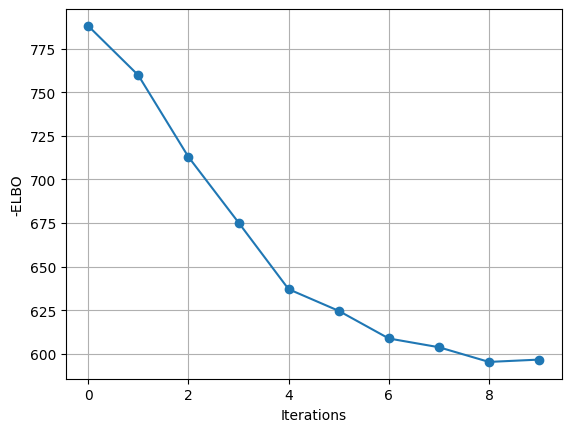

In [25]:
iterations = len(errors['objVal'])
plt.plot(range(iterations), errors['objVal'], marker='o', linestyle='-', label='ELBOW')
plt.xlabel('Iterations')
plt.ylabel('-ELBO')
# plt.title('ELBO vs EM iterations')
plt.grid(True)
plt.savefig(f'./ELBO_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()

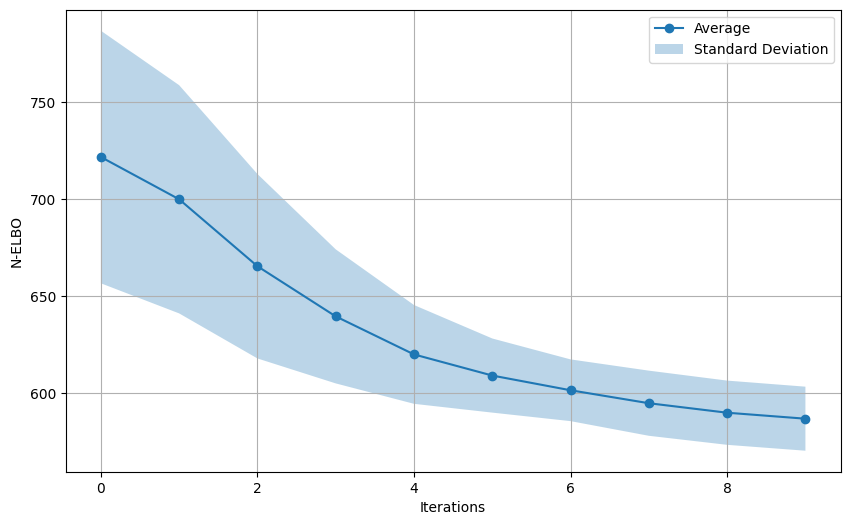

In [29]:
average_values = np.mean([ts for ts in data.values()], axis=0)
std_deviation = np.std([ts for ts in data.values()], axis=0)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(average_values, marker='o', label='Average')

# Fill between average - std_dev and average + std_dev
plt.fill_between(range(len(average_values)), average_values - std_deviation, average_values + std_deviation, alpha=0.3, label='Standard Deviation')

plt.xlabel('Iterations')
plt.ylabel('N-ELBO')
# plt.title('Average Value and Standard Deviation')
plt.legend()
plt.grid(True)
plt.savefig(f'./ELBO_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [27]:
data

{0: [567.4285554780328,
  575.3759524321944,
  568.6644387813092,
  576.0456887402114,
  574.8071644947718,
  570.9696445149084,
  569.2402548691604,
  568.9384932773903,
  568.7450905713907,
  561.4618040075254],
 1: [747.2948944692279,
  707.8328847834504,
  669.3352439433032,
  637.4488919438547,
  615.7261946427654,
  611.969340514629,
  614.4032950653173,
  607.921824379224,
  603.841088930061,
  598.1661060810331],
 2: [783.6204811883514,
  776.471387712539,
  733.997547391573,
  700.7345486788715,
  672.4134861312571,
  645.6668806251664,
  631.9897837740384,
  627.9696638729741,
  624.5394107844606,
  615.8604268252387],
 3: [773.8780024928441,
  753.7059010337331,
  706.7249630113281,
  664.6315286484892,
  635.595094731839,
  611.9994093927298,
  588.1106827653086,
  583.7588263574295,
  575.8302432079224,
  572.7987016531221],
 4: [721.6012369553546,
  693.5841468885694,
  651.5950630248577,
  628.8699583765622,
  617.7218846424078,
  603.3404650535499,
  602.905011277833,
 